In [1]:
# Include so results on different machines are (should be) the same.
import numpy as np
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

import random as rn
rn.seed(3)

In [2]:
!jupyter nbconvert --to script Keras_BagnallCharacter_SimpleRNN.ipynb

[NbConvertApp] Converting notebook Keras_BagnallCharacter_SimpleRNN.ipynb to script
[NbConvertApp] Writing 14390 bytes to Keras_BagnallCharacter_SimpleRNN.py


In [3]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
#     "Dwight D. Eisenhower",
#     "Franklin D. Roosevelt",
#     "George Bush",
#     "George W. Bush",
#     "Gerald R. Ford",
#     "Harry S. Truman",
#     "Herbert Hoover",
#     "Jimmy Carter",
#     "John F. Kennedy",
#     "Lyndon B. Johnson",
    "Richard Nixon",
#     "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
#     "Eisenhower": "Dwight D. Eisenhower",
#     "Roosevelt": "Franklin D. Roosevelt",
#     "Bush": "George Bush",
#     "WBush": "George W. Bush",
#     "Ford": "Gerald R. Ford",
#     "Truman": "Harry S. Truman",
#     "Hoover": "Herbert Hoover",
#     "Carter": "Jimmy Carter",
#     "Kennedy": "John F. Kennedy",
#     "Johnson": "Lyndon B. Johnson",
    "Nixon": "Richard Nixon",
#     "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 30 speeches for 2 presidents.
Loaded 271 speeches for 4 presidents.


In [4]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    loaded_text[x] = re.sub('--', '-', loaded_text[x])
    loaded_text[x] = re.sub('\n\n', '\n', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]+', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

print "Replacements complete."

Replacements complete.


In [5]:
# Have a look at a scrubbed text excerpt
print loaded_text[10][:750]

Thank you. Thank you, everybody. I am thrilled to be here in the great state of Kentucky and the beautiful city of Louisville And this place is packed. There are a lot of people outside that arent getting in, but thats all right. We love them, too, right? We love them, too. 
Were in the heartland of America, and there is no place I would rather be than here with you, tonight. Our first Republican President, Abraham Lincoln, was born right here in Kentucky. Thats not bad. The legendary pioneer, Daniel Boone, helped settle the Kentucky frontier. And the great 7th century American statesman, Henry Clay, represented Kentucky in the United States Congress. Henry Clay believed in what he called the American system, and proposed tariffs to protect


In [6]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4869126
1  : Donald J. Trump      	555750
2  : Richard Nixon        	969424
3  : William J. Clinton   	1765554

Minimum number of characters per president?
555750


In [7]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


Unique char count: 68

Chars w/ counts:
[(1457387, ' '), (796253, 'e'), (662520, 't'), (509216, 'o'), (505983, 'a'), (458738, 'n'), (441235, 'i'), (382664, 's'), (367217, 'r'), (329612, 'h'), (235045, 'l'), (218823, 'd'), (174242, 'u'), (171312, 'c'), (145105, 'm'), (137963, 'w'), (135215, 'g'), (121371, 'p'), (115952, 'f'), (114475, 'y'), (89169, 'b'), (82410, ','), (74920, 'v'), (74466, '.'), (52596, 'k'), (45462, 'I'), (38217, "'"), (27813, 'A'), (16728, 'S'), (16060, 'T'), (13414, '-'), (11355, 'W'), (9515, 'x'), (9233, '7'), (9095, 'j'), (9044, 'C'), (7842, 'B'), (7682, 'P'), (7267, 'N'), (6606, 'M'), (5957, 'R'), (5425, 'q'), (5346, 'E'), (5031, 'O'), (4780, 'U'), (4530, 'G'), (4080, 'H'), (3830, 'z'), (3744, 'D'), (3720, 'L'), (3334, 'F'), (2881, '?'), (2617, '\n'), (2437, ';'), (2179, 'Y'), (2149, 'J'), (1573, '"'), (1497, 'K'), (1476, 'V'), (1401, ':'), (1244, '/'), (699, '$'), (435, 'Q'), (150, 'Z'), (107, 'X'), (6, '#'), (4, '\\')]


In [18]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 50

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Subsequence total count; subsequence label total count:", len( split_text ), len( split_labels )
print "\nTotal characters:", len( split_text ) * max_seq_len

Subsequence total count; subsequence label total count: 163196 163196

Total characters: 8159800


In [19]:
# Have a look at a few split text excerpts
print split_text[10:15]
print split_labels[10:15]

[[9, 7, 6, 17, 1, 14, 11, 4, 13, 12, 8, 1, 5, 6, 12, 1, 9, 5, 17, 7, 6, 17, 1, 8, 3, 4, 9, 15, 8, 24, 1, 28, 3, 1, 3, 10, 2, 8, 2, 1, 15, 4, 15, 2, 6, 3, 8, 22, 1, 28], [15, 2, 9, 7, 14, 5, 1, 10, 5, 8, 1, 14, 5, 9, 9, 7, 2, 12, 1, 4, 6, 1, 6, 4, 3, 1, 8, 7, 15, 18, 11, 20, 1, 21, 2, 14, 5, 13, 8, 2, 1, 4, 19, 1, 3, 10, 2, 1, 8, 25], [7, 11, 11, 1, 4, 9, 1, 23, 7, 8, 7, 4, 6, 1, 4, 19, 1, 3, 10, 4, 8, 2, 1, 7, 6, 1, 10, 7, 17, 10, 1, 4, 19, 19, 7, 14, 2, 22, 1, 21, 13, 3, 1, 21, 2, 14, 5, 13, 8, 2], [1, 16, 2, 1, 3, 10, 2, 1, 18, 2, 4, 18, 11, 2, 1, 10, 5, 23, 2, 1, 9, 2, 15, 5, 7, 6, 2, 12, 1, 19, 5, 7, 3, 10, 19, 13, 11, 1, 3, 4, 1, 3, 10, 2, 1, 7, 12, 2, 5, 11], [8, 1, 4, 19, 1, 4, 13, 9, 1, 19, 4, 9, 2, 21, 2, 5, 9, 8, 1, 5, 6, 12, 1, 3, 9, 13, 2, 1, 3, 4, 1, 4, 13, 9, 1, 19, 4, 13, 6, 12, 7, 6, 17, 1, 12, 4, 14, 13, 15, 2]]
[0, 0, 0, 0, 0]


In [20]:
#
# split amongst speaker samples, not the whole population of samples; shuffle if requested
#
import sklearn.utils

def split_test_train(input_text, input_labels, labels, train_pct=0.8, shuffle_p=True):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))

        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]

    if shuffle_p:
        test_text, test_labels = sklearn.utils.shuffle(test_text, test_labels)
        train_text, train_labels = sklearn.utils.shuffle(train_text, train_labels)

    return train_text, train_labels, test_text, test_labels

In [21]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.8, shuffle_p=False)
print "Sample splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)##

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(train_y), train_y)).tolist()
y_weights = dict(zip(sorted(labels.values()), y_weights))
print "\nClass weights:\n", y_weights

Sample splits:
 Test =  130555 
 Train =  32641

Class weights:
{0: 0.4189557794750016, 1: 3.6705746738641474, 2: 2.1043681495809157, 3: 1.1554357830642878}


In [22]:
# Have a look at a few of the split text excerpts; 
# likely the same classes based on the split point
print train_X[10:15]
print train_y[10:15]

[[9, 7, 6, 17, 1, 14, 11, 4, 13, 12, 8, 1, 5, 6, 12, 1, 9, 5, 17, 7, 6, 17, 1, 8, 3, 4, 9, 15, 8, 24, 1, 28, 3, 1, 3, 10, 2, 8, 2, 1, 15, 4, 15, 2, 6, 3, 8, 22, 1, 28], [15, 2, 9, 7, 14, 5, 1, 10, 5, 8, 1, 14, 5, 9, 9, 7, 2, 12, 1, 4, 6, 1, 6, 4, 3, 1, 8, 7, 15, 18, 11, 20, 1, 21, 2, 14, 5, 13, 8, 2, 1, 4, 19, 1, 3, 10, 2, 1, 8, 25], [7, 11, 11, 1, 4, 9, 1, 23, 7, 8, 7, 4, 6, 1, 4, 19, 1, 3, 10, 4, 8, 2, 1, 7, 6, 1, 10, 7, 17, 10, 1, 4, 19, 19, 7, 14, 2, 22, 1, 21, 13, 3, 1, 21, 2, 14, 5, 13, 8, 2], [1, 16, 2, 1, 3, 10, 2, 1, 18, 2, 4, 18, 11, 2, 1, 10, 5, 23, 2, 1, 9, 2, 15, 5, 7, 6, 2, 12, 1, 19, 5, 7, 3, 10, 19, 13, 11, 1, 3, 4, 1, 3, 10, 2, 1, 7, 12, 2, 5, 11], [8, 1, 4, 19, 1, 4, 13, 9, 1, 19, 4, 9, 2, 21, 2, 5, 9, 8, 1, 5, 6, 12, 1, 3, 9, 13, 2, 1, 3, 4, 1, 4, 13, 9, 1, 19, 4, 13, 6, 12, 7, 6, 17, 1, 12, 4, 14, 13, 15, 2]]
[0, 0, 0, 0, 0]


In [23]:
#
# One-hot encoding classes & samples
#
from keras.utils import to_categorical

# one-hot encode classes
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

# one-hot encode samples
train_X = np.array(train_X)
orig_train_X_size=train_X.shape[0]
print "Encoding train_X with dimensions ", train_X.shape
train_X = to_categorical(train_X, num_classes=unique_chars)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(orig_train_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
orig_test_X_size=test_X.shape[0]
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = to_categorical(test_X, num_classes=unique_chars)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(orig_test_X_size,max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape

Encoding train_X with dimensions  (130555, 50)
...to  (6527750, 68)
...and reshaping to  (130555, 50, 68)

Encoding test_X with dimensions  (32641, 50)
...to  (1632050, 68)
...and reshaping to  (32641, 50, 68)


In [24]:
# Have a again look at a few of the split and encoded text excerpts; 
# both arrays should be one-hot encoded.
print train_X[10:11]
print train_y[10:11]

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
[[ 1.  0.  0.  0.]]


In [25]:
# custom activation from Bagnall 2015
#  we were never able to get this to work; either nan'ed or never converged
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects

def ReSQRT(x):
    cond = tf.less_equal(x, 0.0)
    return tf.where(cond, x * 0.0, tf.sqrt(x+1)-1)

get_custom_objects().update({'ReSQRT': ReSQRT})

Bagnall proposes that the following possible values contribute to the success of the model:

| meta-parameter                  	| typical value                      	|
|---------------------------------	|------------------------------------	|
| initial adagrad learning scale  	| 0.1, 0.14, 0.2, 0.3                	|
| initial leakage between classes 	| 1/4N to 5/N                        	|
| leakage decay (per sub-epoch)   	| 0.67 to 0.9                        	|
| hidden neurons                  	| 79, 99, 119, 139                   	|
| presynaptic noise σ             	| 0, 0.1, 0.2, 0.3, 0.5              	|
| sub-epochs                      	| 6 to 36                            	|
| text direction                  	| forward or backward                	|
| text handling                   	| sequential, concatenated, balanced 	|
| initialisation                  	| gaussian, zero                     	|

In [30]:
##
## BASELINE
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional, Dropout
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adagrad, adam
from keras.models import Model
from keras.utils import plot_model

# define operating vars
batch_size = 50
epochs = 100

# define optimizer
optimizer = Adagrad(lr=0.001)

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5,
              patience=1, verbose=1)
csv_logger = CSVLogger('Keras_BagnallCharacter_SimpleRNN.log')

# assemble & compile model
main_input = Input(shape=(max_seq_len,unique_chars,))
rnn = Bidirectional(SimpleRNN(units=100,activation="tanh"))(main_input)
drop = Dropout(0.2)(rnn)
main_output = Dense(len(labels),activation='softmax',kernel_initializer='random_uniform')(drop)
model = Model(inputs=[main_input], outputs=[main_output])

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])
plot_model(model, to_file='Keras_BagnallCharacter_SimpleRNN.png', show_shapes=True, show_layer_names=True)
print(model.summary())


# train
model.fit([np.array(train_X)],
          [np.array(train_y)],
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_BagnallCharacter_SimpleRNN-4Speakers.h5')  
del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 68)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               33800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 804       
Total params: 34,604
Trainable params: 34,604
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
130555/130555 [==============================] - 88s - loss: 1.3901 - categorical_accuracy: 0.2468    
Epoch 2/100
 93150/130555 [====================>.........] - ETA: 25s - loss: 1.3912 - categorical_accuracy: 0.2468

KeyboardInterrupt: 

In [ ]:
# Load computed model
from keras.models import load_model
# returns a compiled model identical to the one trained
model = load_model('Keras_BagnallCharacter_SimpleRNN-4Speakers.h5')

In [28]:
from sklearn import metrics

# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)
print "\n\nDone prediction."

print "\nAUC = ", metrics.roc_auc_score(test_y, pred_y)

Evaluating test data...
32512/32641 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[1.2954933346824347, 0.36405134646610093]

Predicting using test data...
32450/32641 [============================>.] - ETA: 0s

Done prediction.

AUC =  0.627069533609


Confusion matrix, without normalization
[11434  5961 12526  2720]
[[7939 3343 6586 1609]
 [ 733  775  581  134]
 [ 541  487 2521  329]
 [2221 1356 2838  648]]
Normalized confusion matrix
[[ 0.41  0.17  0.34  0.08]
 [ 0.33  0.35  0.26  0.06]
 [ 0.14  0.13  0.65  0.08]
 [ 0.31  0.19  0.4   0.09]]


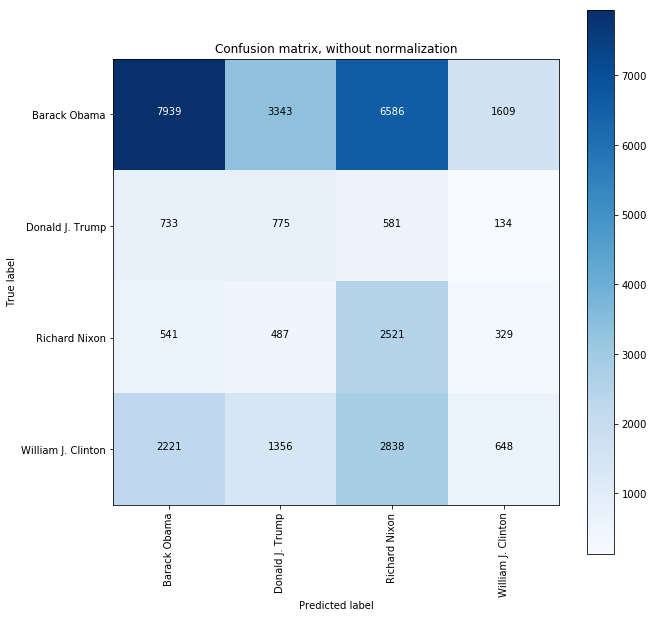

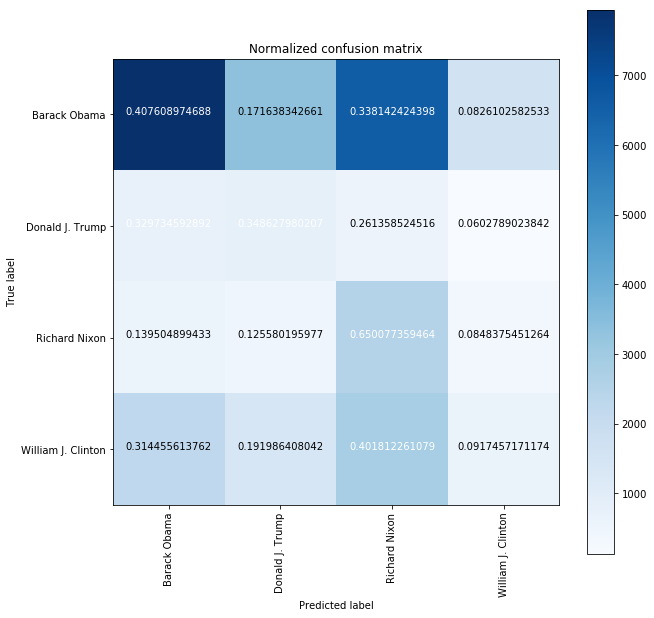

In [29]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(np.sum(cm,axis=0))

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(np.round(cnf_matrix,2), classes=(sorted(labels, key=labels.get)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()